In [1]:
import pickle
from functools import partial
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import spearmanr
import functions


In [2]:
#Initial 'guess' values
#Smith's flexibility used as initial weights had slightly greater
# AUC than Vihinen. So we use it as starting point in optimisation.
#Smith, David K., et al. 2003
flexibilities_smith = {'A': 0.717, 'C': 0.668, 'E': 0.963, 'D': 0.921,\
                         'G': 0.843, 'F': 0.599, 'I': 0.632, 'H': 0.754, \
                         'K': 0.912, 'M': 0.685, 'L': 0.681, 'N': 0.851,\
                         'Q': 0.849, 'P': 0.85, 'S': 0.84, 'R': 0.814, 'T': 0.758, \
                         'W': 0.626, 'V': 0.619, 'Y': 0.615}
init_state = [v for k, v in flexibilities_smith.items()]


In [65]:
with open('results/training.pkl', 'rb') as handle:
    training_with_his = pickle.load(handle)


In [66]:
with open('results/testing.pkl', 'rb') as h:
    testing_with_his = pickle.load(h)

# Remove his tag

In [68]:
def remove_his_tag(list_of_dfs):
    cleaned = []
    for i, v in enumerate(list_of_dfs):
        v['pET21'] = v.Accession.apply(lambda x:x.split('_')[1] == 'pET21')
        a = v.loc[v['pET21'] == True]
        b = v.loc[v['pET21'] == False]
        c = pd.concat([a, b]).reset_index(drop=True)
        cleaned.append(c)
    return cleaned
        

training = remove_his_tag(training_with_his)
testing = remove_his_tag(testing_with_his)

In [78]:
def avr_arr(arr):
    tt = pd.DataFrame({'weights':arr})
    tt = pd.DataFrame(tt.weights.tolist(), columns=[k for k,v in flexibilities_smith.items()])
    return tt.mean().values


# Bootstrap

In [71]:
bs_samples = []
for i, v in enumerate(training):
    sample = []
    for i in range(1000): #1000 resample for each training cross validation step
        sol = v.loc[v['Solubility'] == 1].sample(1000, random_state=i)
        insol = v.loc[v['Solubility'] == 0].sample(1000, random_state=i)
        sample.append(sol.append(insol))
    bs_samples.append(sample)


In [76]:
import multiprocessing
from multiprocessing import Pool





optis_full = [] #full results of optimisation
weights_full_bs = []
aucs_train_full_bs = []

for i, v in enumerate(bs_samples):
    pools = Pool(multiprocessing.cpu_count())
    optis = []
    weights = []
    aucs_train = []
    cost_funcs = [partial(functions.cost_func, df=t) for t in v]
    optimiser = partial(optimize.minimize, x0=init_state, method="Nelder-Mead", \
                             options={ 'maxiter': 3000, 'maxfev': 3000,\
                           'disp': False, 'return_all': False,\
                           'xatol': 0.001, 'fatol': 0.0001, 'adaptive': True})
    
    for result in pools.map(optimiser, cost_funcs): #map is used for correct orders
        optis.append(result)
        aucs_train.append(-result['fun'])
        weights.append(result['x'])
    pools.close()
    pools.join()
    optis_full.append(optis)
    weights_full_bs.append(weights)
    aucs_train_full_bs.append(aucs_train)
    print(i)

    
cross_val_df = pd.DataFrame({'opti': optis_full, 'weights_bs':weights_full_bs, \
                             'aucs_train_bs':aucs_train_full_bs})


In [79]:
cross_val_df['weight'] = cross_val_df['weights_bs'].apply(avr_arr)
aucs_train = [-functions.cost_func(cross_val_df.weight[i], t) for i, t in enumerate(training)]
aucs_test = [-functions.cost_func(cross_val_df.weight[i], t) for i, t in enumerate(testing)]
cross_val_df['aucs_train'] = aucs_train
cross_val_df['aucs_test'] = aucs_test
cross_val_df.to_pickle('results/cross_validation_without_his_tag.pkl.gz', compression='infer')

In [80]:
cross_val_df.head(2)

,opti,weights_bs,aucs_train_bs,weight,aucs_train,aucs_test
0,"[{'fun': -0.7430019999999999, 'nit': 614, 'nfe...","[[0.8243604864837748, 0.5576477489516017, 0.95...","[0.7430019999999999, 0.7261865, 0.727299500000...","[0.8394392218050214, 0.51231687904088, 0.98961...",0.722218,0.685323
1,"[{'fun': -0.715525, 'nit': 600, 'nfev': 1383, ...","[[0.8473626092684315, 0.5818601504237649, 0.96...","[0.715525, 0.7063364999999999, 0.711913, 0.714...","[0.8309294368834936, 0.5140622580441093, 0.989...",0.717483,0.723102


In [6]:
mean_std = pd.DataFrame(index=['Training', 'Test'])
mean_std.loc['Training', 'Mean'] = np.mean(cross_val_df['aucs_train'])
mean_std.loc['Training', 'Std'] = np.std(cross_val_df['aucs_train'])
mean_std.loc['Test', 'Mean'] = np.mean(cross_val_df['aucs_test'])
mean_std.loc['Test', 'Std'] = np.std(cross_val_df['aucs_test'])
mean_std

,Mean,Std
Training,0.718747,0.003489
Test,0.710517,0.030902


[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10')]

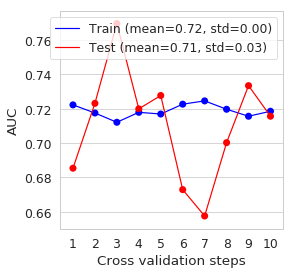

In [4]:
cross_val_df = pd.read_pickle('results/cross_validation_without_his_tag.pkl.gz')





functions.plt.figure(figsize=(4, 4))
functions.sns.pointplot(list(range(10)), cross_val_df['aucs_train'], label='Train (mean=0.72, std=0.00)',\
                       linestyles=[' '], markers=['o'], color='blue')
functions.sns.lineplot(list(range(10)), cross_val_df['aucs_train'], label='Train (mean=0.72, std=0.00)',\
                       color='blue')
functions.sns.pointplot(list(range(10)), cross_val_df['aucs_test'],  label='Test (mean=0.71, std=0.03)',\
                        linestyles=[''], markers=['o'], color='red')
ax = functions.sns.lineplot(list(range(10)), cross_val_df['aucs_test'],  label='Test (mean=0.71, std=0.03)',\
                        color='red')
functions.plt.ylabel('AUC')
functions.plt.xlabel('Cross validation steps')

ax.set_xticklabels(list(range(1,11)))
# functions.plt.savefig('figs/cross_validation_test_train_without_his_tag.pdf')


In [83]:
AAS_cv = pd.DataFrame(cross_val_df['weight'].values.tolist(), columns=[k for k,v in flexibilities_smith.items()])
AAS_cv.mean()#.sort_values()

A    0.836137
C    0.520509
E    0.987956
D    0.907767
G    0.799600
F    0.584314
I    0.678437
H    0.895804
K    0.926868
M    0.632351
L    0.654342
N    0.859312
Q    0.789860
P    0.821436
S    0.743460
R    0.770800
T    0.809575
W    0.638381
V    0.735531
Y    0.611136
dtype: float64

### Plot weights (initial and final) with hydrophobicity

Text(0.5, 0, 'Amino acids')

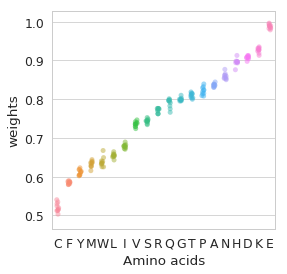

In [8]:
#weight_df
cols = [k for k, v in flexibilities_smith.items()]
wdf = pd.DataFrame(columns=cols, index=list(range(10)))
weights = cross_val_df['weight'].values #weights from CV

for idx, val in enumerate(weights):
    for i, v in enumerate(val):
        wdf.loc[idx][cols[i]] = v

        
dd = pd.melt(wdf)
dd['value'] = dd['value'].astype(float)
dd.sort_values(ascending=True, by='value', inplace=True)


# functions.sns.set(style="white")
functions.plt.figure(figsize=(4, 4))

ax = functions.sns.stripplot(x="variable", y="value", data=dd, alpha=0.5, s=5)
functions.plt.ylabel('weights')
functions.plt.xlabel('Amino acids')
# functions.sns.despine()
# functions.plt.savefig('figs/cross_validation_weights_test.pdf')


## Checking the correlation between these new weights which were derived removing His tags and weights derived with His tags

In [10]:
new_wts = {} #This is AAS

for i, c in enumerate(wdf.columns):
    new_wts[c] = np.mean(wdf[c])
new_wts

{'A': 0.8361372386820893,
 'C': 0.5205085702343379,
 'E': 0.987956369046931,
 'D': 0.9077674681401724,
 'G': 0.7996003139559975,
 'F': 0.5843138638581623,
 'I': 0.678436934795912,
 'H': 0.8958035929000399,
 'K': 0.9268679697782604,
 'M': 0.6323511959075137,
 'L': 0.654341609974262,
 'N': 0.8593118111626608,
 'Q': 0.7898597284378663,
 'P': 0.8214362665643107,
 'S': 0.7434596054279766,
 'R': 0.7708003137293177,
 'T': 0.8095753587860024,
 'W': 0.6383806989269312,
 'V': 0.7355313672466454,
 'Y': 0.6111359802776267}

In [94]:

##Correlation between with and without his tags

from scipy.stats import spearmanr

spearmanr([0.83613724, 0.52050857, 0.98795637, 0.90776747, 0.79960031,
       0.58431386, 0.67843693, 0.89580359, 0.92686797, 0.6323512 ,
       0.65434161, 0.85931181, 0.78985973, 0.82143627, 0.74345961,
       0.77080031, 0.80957536, 0.6383807 , 0.73553137, 0.61113598], [0.83569566, 0.52192073, 0.98686604, 0.90759835, 0.80038279,
       0.58219346, 0.67904493, 0.89639776, 0.92591651, 0.62999641,
       0.65469222, 0.8604957 , 0.789565  , 0.82210442, 0.74424644,
       0.77105515, 0.8098671 , 0.63869319, 0.73449529, 0.61255815])

SpearmanrResult(correlation=1.0, pvalue=0.0)

In [98]:

#For ecoli data

#using AAS
ecoli_w3110 = pd.read_pickle('results/ecoli.pkl.gz', compression='infer')

ecoli_w3110['f'] = ecoli_w3110['Sequence'].apply(lambda x:functions.solubility_score(x, new_wts))
ecoli_w3110['Average_Score'] = ecoli_w3110['f'].apply(lambda x:np.mean(x))



from scipy.stats import spearmanr

spearmanr(ecoli_w3110['Average_Score'], ecoli_w3110['Solubility(%)'])

SpearmanrResult(correlation=0.5040456659351376, pvalue=1.060887637753602e-205)